In [20]:
from pymongo  import MongoClient
import pandas as pd
import numpy as np
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn import decomposition, naive_bayes, preprocessing, model_selection, metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import model_selection
#! pip install scikit-surprise
from surprise import NormalPredictor, BaselineOnly, SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

# Chargement des données AVIS

In [125]:
client = MongoClient(host="localhost", port=27017)
db = client["PLDAC_01"] 
collection = db["avis"]

In [126]:
df_avis = pd.DataFrame(list(collection.find())).loc[:,["author","title","note","date_published"]]
df_avis.head(5)

,author,title,note,date_published
0,Monsieur Guillaume,Mariposas,8.0,2021-01-27 11:06:44
1,morlockbob,Mariposas,7.0,2020-10-18 10:04:21
2,SwatSh,Mariposas,7.0,2021-02-01 08:35:08
3,Timi JeuxATheme,Mariposas,8.0,2020-11-19 17:04:57
4,prunelles,Mariposas,9.0,2021-05-24 12:43:18


In [127]:
num_users  = df_avis["author"].nunique()
num_items  = df_avis["title"].nunique()

print(f"there are {num_users} users and {num_items} items")

there are 13623 users and 10709 items


In [128]:
# on elimine les lignes où un author a note plusieurs fois un jeu
df_avis_unique = df_avis.groupby(['author','title']).value_counts()
df_avis_unique.head(10)

author            title                                note  date_published     
#yuyu#            Bubblee Pop                          8.5   2019-01-19 23:11:33    2
                  KARMAKA                              8.8   2018-02-25 09:01:19    2
$hadow            Le Dilemme du Roi                    9.0   2021-01-03 21:14:16    5
$lebat@$          Deluxe Camping                       10.0  2007-11-06 12:28:47    1
&lo               Sporz Original Outbreak              10.0  2011-01-18 12:28:59    1
*FitzChevalerie*  7 Wonders - Extension "Cities"       8.0   2012-11-20 13:36:22    1
                  7 Wonders - Extension "Wonder Pack"  7.4   2013-10-14 20:35:59    1
                  A Few Acres of Snow                  10.0  2012-05-23 12:29:05    1
                  Archipelago                          10.0  2012-10-16 13:36:22    1
                  Archipelago : Solo Expansion         10.0  2012-12-06 18:14:14    1
dtype: int64

## Suppression des duplications

In [129]:
df_avis = df_avis.drop_duplicates(subset=['author','title','note','date_published'])
df_avis.head()

,author,title,note,date_published
0,Monsieur Guillaume,Mariposas,8.0,2021-01-27 11:06:44
1,morlockbob,Mariposas,7.0,2020-10-18 10:04:21
2,SwatSh,Mariposas,7.0,2021-02-01 08:35:08
3,Timi JeuxATheme,Mariposas,8.0,2020-11-19 17:04:57
4,prunelles,Mariposas,9.0,2021-05-24 12:43:18


In [139]:
df_avis = df_avis[['author','title','note']]
num_users  = df_avis["author"].nunique()
num_items  = df_avis["title"].nunique()

print(f"there are {num_users} users and {num_items} items")

there are 13623 users and 10709 items


### 1. Nombre d'utilisateurs en fonction du nombre minimum de notes.

In [229]:
import seaborn as sns
import matplotlib.pyplot as plt

l_min = [0,5,10,20,30,50,100,200,300]
n_authors = []
tailles_df = []

authors_counts = df_avis['author'].value_counts()
for min_note in l_min:
  authors = authors_counts[authors_counts >= min_note].index.to_list()
  n_authors.append(np.unique(authors).shape[0])
  
  df_avis_k = df_avis[df_avis['author'].isin(authors)]
  tailles_df.append(len(df_avis_k))

print("Nombre minimums de notes requis:\n  ",l_min)
print("Liste du nombre d'authors restants:\n  ",n_authors)
print("Taille de la base resultante:\n  ",tailles_df)

Nombre minimums de notes requis:
   [0, 5, 10, 20, 30, 50, 100, 200, 300]
Liste du nombre d'authors restants:
   [13623, 4701, 2849, 1631, 1176, 734, 359, 128, 61]
Taille de la base resultante:
   [176182, 161268, 149070, 132486, 121520, 104609, 78628, 46249, 29916]


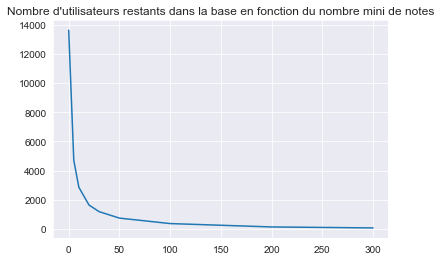

In [140]:
sns.set_style("darkgrid")
sns.lineplot(x=l_min,y=n_authors)
plt.title("Nombre d'utilisateurs restants dans la base en fonction du nombre mini de notes")
plt.show()

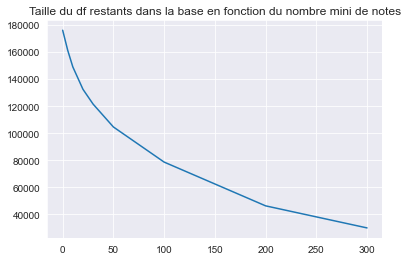

In [141]:
sns.set_style("darkgrid")
sns.lineplot(x=l_min,y=tailles_df)
plt.title("Taille du df restants dans la base en fonction du nombre mini de notes")
plt.show()

## Suppression des autheurs qui ont noté moins de 10 jeux

In [200]:
print(f"Taille du df avant {len(df_avis)}")
# Taille du df avant 246524

authors = df_avis['author'].value_counts()
authors = authors[authors >= 300].index.to_list()

df_avis_k = df_avis[df_avis['author'].isin(authors)]
print(f"Taille du df après {len(df_avis_k)}")
# Taille du df après 5925

Taille du df avant 176182
Taille du df après 29916


In [201]:
# on elimine les lignes où un author a note plusieurs fois un jeu
# on fait la note moyenne

df_avis_k_unique = df_avis_k.groupby(['author','title'])['note'].mean().to_dict()
avis_un = []

for at,note in df_avis_k_unique.items():
  author,title = at
  avis_un.append((author,title,note))

df_avis_un = pd.DataFrame(avis_un,columns=df_avis_k.columns)
df_avis_un.head()

,author,title,note
0,--- JD ---,30 Carats,5.7
1,--- JD ---,6 qui prend !,8.3
2,--- JD ---,7 Wonders Duel,8.0
3,--- JD ---,Abracada Quoi,7.7
4,--- JD ---,Abyss,7.2


In [202]:
print('Nombre de notes restants:', len(df_avis_un))

Nombre de notes restants: 29867


## Test/Train split

In [203]:

X_train, X_test = model_selection.train_test_split(df_avis_un, test_size=0.2, random_state=0)
df_avis.head()

,author,title,note
0,Monsieur Guillaume,Mariposas,8.0
1,morlockbob,Mariposas,7.0
2,SwatSh,Mariposas,7.0
3,Timi JeuxATheme,Mariposas,8.0
4,prunelles,Mariposas,9.0


In [204]:
print("Nombre d'utilisateurs restants dans l'ensemble d'apprentissage:\n  ",X_train['author'].nunique())
print("Nombre d'utilisateurs restants dans l'ensemble de test:\n  ",X_test['author'].nunique())

Nombre d'utilisateurs restants dans l'ensemble d'apprentissage:
   61
Nombre d'utilisateurs restants dans l'ensemble de test:
   61


Cas où les utilisateurs ont noté plus de 10 jeux.
- Nombre d'utilisateurs restants dans l'ensemble de la base: **2849**
- Nombre d'utilisateurs restants dans l'ensemble d'apprentissage: **2849**</br>
- Nombre d'utilisateurs restants dans l'ensemble de test: **2786**

Cas où les utilisateurs ont noté plus de 100 jeux.
- Nombre d'utilisateurs restants dans l'ensemble de la base: **359**
- Nombre d'utilisateurs restants dans l'ensemble d'apprentissage: **359**</br>
- Nombre d'utilisateurs restants dans l'ensemble de test: **359**

Cas où les utilisateurs ont noté plus de 300 jeux.
- Nombre d'utilisateurs restants dans l'ensemble de la base: **61**
- Nombre d'utilisateurs restants dans l'ensemble d'apprentissage: **61**</br>
- Nombre d'utilisateurs restants dans l'ensemble de test: **61**

## Mean Reciprocal Rank 

$$ MRR = \frac{1}{|Q|}\sum^{|Q|}_{i=1}\frac{1}{\text{rank}_i} $$

In [205]:
def rr(list_items):
    relevant_indexes = np.asarray(list_items).nonzero()[0]
    
    if len(relevant_indexes) > 0:
        
        #NOTE:
        # relevant_indexes[0] <= Contains the index of the 1st relevant item ([0,0,1] => 2)
        
        return 1 / (relevant_indexes[0] + 1)
    else:
        return 0

def mrr(list_list_items):
    rr_list = [rr(list_items) for list_items in list_list_items]
    return np.mean(rr_list)

## Discounted Cumulative Gain

$$DCG_p = \sum^p_{i=1}\frac{rel_i}{\log_2{(i+1)}} = rel_1 + \sum^p_{i=2}\frac{rel_i}{\log_2{(i+1)}}$$

In [206]:
def dcg_at_k(r, k):
    """Score is discounted cumulative gain (dcg)
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        
    """
    r = np.asfarray(r)[:k]
    if r.size:
        return r[0] +  np.sum(r[1:] / np.log2(np.arange(3, r.size + 2)))
        
    return 0.

$$ nDCG_p = \frac{DCG_p}{IDCG_p} $$


$$ IDCG_p = max(DCG_p) $$

In [207]:
def ndcg_at_k(r, k):
    """
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
    """
    dcg_max =  np.max(dcg_at_k(sorted(r)[::-1], k))
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k)/dcg_max

- `already_seen`: Items that were already seen by users. This is for training and not recommending them again
- `ground_truth`: Items that will be seen and liked (rating >= 10) by users. This is our ground truth to evaluate our predictions.

In [208]:
already_seen = (
    X_train
    .groupby("author")["title"]
    .apply(list)
    .to_dict()
    )

ground_truth = (
    X_test[X_test.note >= 10] 
    .groupby("author")["title"]
    .apply(list)
    .to_dict()
    )

### We also need the set of all items that can be recommended

In [209]:
existing_items = set(X_train["title"].unique())
print("The recommender system will have to pick a few items from",len(existing_items),"possible items")

The recommender system will have to pick a few items from 6358 possible items


#  Surprise SVD recommender

In [210]:
from surprise import Dataset

data = Dataset.load_from_df(X_train[['author', 'title', 'note']], Reader(rating_scale=(1, 10)))
model = SVD()
model.fit(data.build_full_trainset())

In [211]:
def svd_rating_pred(user_item):
    user = user_item["author"]
    item = user_item["title"]
    
    prediction = model.predict(user,item)
    
    return prediction.est

X_test["svd_prediction"] = X_test[["author","title"]].apply(svd_rating_pred,axis=1) 

In [212]:
mse = ((X_test["note"] - X_test["svd_prediction"])**2).mean()
mae = ((X_test["note"] - X_test["svd_prediction"]).abs()).mean()

print(f"MSE: {mse} -- MAE: {mae}")

# MSE: 2.3801853240165443 -- MAE: 1.085783922356087

MSE: 3.351007998083854 -- MAE: 1.4199256694635638


In [213]:
def model_rating_pred(model,user,item):
    prediction = model.predict(user,item)
    return prediction.est

###  the relevance list for our MRR function

In [214]:
list_of_rel = []
    

for user,will_see in ground_truth.items():
    rel_list = []
    will_see = set(will_see)
    has_seen = set(already_seen[user])
    can_see = [(mid,model_rating_pred(model,user,mid)) for mid in existing_items - has_seen]
    
    
    for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
        if movie in will_see:
            rel_list.append(1)
            break
        else:
            rel_list.append(0)        
    rel_list[-1] = 1 # when no relevant item exist
    list_of_rel.append(rel_list)
    

svd_mrr = mrr(list_of_rel)

In [215]:
f"On average, the {int(round(1/svd_mrr,0))}th proposed item is relevant (on {len(existing_items)})"

'On average, the 7th proposed item is relevant (on 6358)'

- En éliminant les utilisateurs ayant noter moins de **300** jeux nous avons une mrr de **7** sur **6358**. </br>

- En éliminant les utilisateurs ayant noter moins de **100** jeux nous avons une mrr de **13** sur **8258**. </br>

- En éliminant les utilisateurs ayant noter moins de **10** jeux nous avons une mrr de **35** sur **9690**.

# Implicit baseline: popular items

In [216]:
item_counts = X_train.groupby('title')["note"].count().sort_values(ascending=False)
popular_item_list = item_counts.index.tolist()

In [217]:
print(len(popular_item_list))

6358


In [218]:
print(popular_item_list[:10])

['Race for the Galaxy', "L'Âge de Pierre", 'Les Chevaliers de la Table Ronde', 'Pingouins', 'Caylus', 'Coloretto : 10 ans déjà', 'Dominion', 'Citadelles : quatrième édition', 'Small World', 'Saint Pétersbourg']


### popular recommendation relevance list per user

In [219]:
list_of_rel = []

for user,will_see in ground_truth.items():
    rel_list = []
    will_see = set(will_see)
    has_seen = set(already_seen[user])
    
    for movie in popular_item_list:
        if movie in has_seen:         # User has already seen movie -> Can filter prediction
            continue
        elif movie in will_see:       # User will see, spot on suggestion !         
            rel_list.append(1) # To Complete
            break
        else:                         # No clue.
            rel_list.append(0) # To Complete
            
    if rel_list[-1] == 1:             # when no relevant item exist, no need to take it into account.
        list_of_rel.append(rel_list)

In [220]:
pop_mrr = mrr(list_of_rel)
f"On average, the {int(round(1/pop_mrr,0))}th proposed item is relevant (on {len(existing_items)})"

'On average, the 6th proposed item is relevant (on 6358)'

- En éliminant les utilisateurs ayant noter moins de **300** jeux nous avons une mrr de **6** sur **6358**. </br>

- En éliminant les utilisateurs ayant noter moins de **100** jeux nous avons une mrr de **10** sur **8258**. </br>

- En éliminant les utilisateurs ayant noter moins de **10** jeux nous avons une mrr de 58 sur **9690**.

# Implicit Collaborative Filtering 

## Interaction train/test dataset within the framework

In [221]:
from lightfm.data import Dataset

# (a) Create a dataset
dataset = Dataset()


# (b) Create an internal mapping for users and items (We need to consider train + test)
dataset.fit((x for x in df_avis_k["author"]),
            (x for x in df_avis_k["title"]))

# (c) Create the interaction matrices
(train_interactions, weights) = dataset.build_interactions(
    ((x.author, x.title) for x in X_train.itertuples() if x.note >= 10) # We only consider 5's as interactions
) 
(test_interactions, weights) = dataset.build_interactions(
    ((x.author, x.title) for x in X_test.itertuples() if x.note >= 10)  # We only consider 5's as interactions
) 

In [222]:
print(f"train interactions: {train_interactions.shape}")
print(f"test interactions : {test_interactions.shape}")

train interactions: (61, 6941)
test interactions : (61, 6941)


In [223]:
print(f"train interactions: {sum(X_train['note']>=10)}")
print(f"train interactions: {sum(X_test['note']>=10)}")


train interactions: 3472
train interactions: 798


## Train the lightFM model

In [224]:
from lightfm import LightFM

model = LightFM(loss='bpr',random_state=50000)
model.fit(train_interactions)

In [225]:
from lightfm.evaluation import reciprocal_rank
bpr_mrr = reciprocal_rank(model, test_interactions, train_interactions).mean()

In [226]:
f"On average, the {int(round(1/bpr_mrr,0))}th proposed item is relevant (on {len(existing_items)})"

'On average, the 10th proposed item is relevant (on 6358)'

- En éliminant les utilisateurs ayant noter moins de **300** jeux nous avons une mrr de **10** sur **6358**. </br>

- En éliminant les utilisateurs ayant noter moins de **100** jeux nous avons une mrr de **10** sur **8258**. </br>

- En éliminant les utilisateurs ayant noter moins de **10** jeux nous avons une mrr de **53** sur **9690**.

## We consider EVERY rating as one interaction

In [227]:
# Create the interaction matrix
(train_interactions_all, weights) = dataset.build_interactions(
    ((x.author, x.title) for x in X_train.itertuples()) # We only consider 5's as interactions
) 
(test_interactions_all, weights) = dataset.build_interactions(
    ((x.author, x.title) for x in X_test.itertuples())  # We only consider 5's as interactions
) 

from lightfm import LightFM


model_bpr_all = LightFM(loss='bpr',random_state=50000)
model_bpr_all.fit(train_interactions_all)

bpr_mrr_all = reciprocal_rank(model_bpr_all, test_interactions_all, train_interactions_all).mean()

In [228]:
f"On average, the {int(round(1/bpr_mrr_all,0))}th proposed item is relevant (on {len(existing_items)})"

# 'On average, the 34th proposed item is relevant (on 9819)'

'On average, the 3th proposed item is relevant (on 6358)'

En éliminant les utilisateurs ayant noter moins de **300** jeux nous avons une mrr de **3** sur **6358**. </br>

En éliminant les utilisateurs ayant noter moins de **100** jeux nous avons une mrr de **3** sur **8258**. </br>

En éliminant les utilisateurs ayant noter moins de **10** jeux nous avons une mrr de **28** sur **9690**.

## Visualisation avec TSNE

In [232]:
mat = np.zeros((num_users,num_items))
authors = np.unique(df_avis['author'])
authors = dict(zip(authors,range(len(authors))))
titles = np.unique(df_avis['title'])
titles = dict(zip(titles,range(len(titles))))

for i in range(len(df_avis)):
  user,title,note = df_avis.iloc[i]
  user,title = authors[user],titles[title]
  mat[user,title] = note

In [233]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50)
U = svd.fit_transform(mat)

tsne = TSNE(n_components=2,init='pca',n_iter=5000)
tsne_mat = tsne.fit_transform(U)

In [ ]:
plt.scatter(tsne_mat[:,0],tsne_mat[:,1])
plt.show()